# Full-Field Sampling vs Power Spectrum Inference

This notebook compares two approaches to cosmological parameter inference:
1. Full-field inference from convergence maps
2. Power spectrum (2PCF) inference from angular power spectra

We use full-sky configuration (observer at center) to enable anafast power spectrum computation.

## Imports

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import healpy as hp
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import compute_box_size_from_redshift
from fwd_model_tools.plotting import plot_kappa, plot_lightcone, plot_posterior
from fwd_model_tools.powerspec_model import powerspec_probmodel
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


JAX devices: 1
JAX backend: gpu


## Configuration Parameters

In [2]:
output_dir = "output_03_comparison"
box_shape = (16, 16, 16)
max_redshift = 0.5
number_of_shells = 8
geometry = "spherical"
observer_position = (0.5, 0.5, 0.5)
num_warmup = 20
num_samples = 10
batch_count = 2
sampler = "MCLMC"
backend = "blackjax"
sigma_e = 0.3
magick_seed = 42

output_dir_path = Path(output_dir)
plots_dir = output_dir_path / "plots"
samples_dir_ff = output_dir_path / "samples_fullfield"
samples_dir_ps = output_dir_path / "samples_powerspec"
data_dir = output_dir_path / "data"

plots_dir.mkdir(parents=True, exist_ok=True)
samples_dir_ff.mkdir(parents=True, exist_ok=True)
samples_dir_ps.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

fiducial_cosmology = Planck18()
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position)

print(f"Box size: {box_size} Mpc/h")
print(f"Max redshift: {max_redshift}")
print(f"Observer position (full-sky): {observer_position}")

Box size: (2635.3309394476964, 2635.3309394476964, 2635.3309394476964) Mpc/h
Max redshift: 0.5
Observer position (full-sky): (0.5, 0.5, 0.5)


## Setup Sharding and Redshift Distribution

In [3]:
if jax.device_count() > 1:
    from jax.sharding import NamedSharding
    from jax.sharding import PartitionSpec as P

    mesh = jax.make_mesh((4, 2), ("x", "y"))
    sharding = NamedSharding(mesh, P("x", "y"))
    print(f"Using sharding with mesh: (4, 2)")
else:
    sharding = None
    print("Single device mode - no sharding")

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)
print(f"Number of redshift bins: {nbins}")

Single device mode - no sharding
z_centers = [0.2   0.297 0.393 0.49 ]
Number of redshift bins: 4


## Instantiate Full-Field Model

In [4]:
config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    number_of_shells=number_of_shells,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.24, 0.28),
        "sigma8": dist.Uniform(0.78, 0.82),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=True,
    log_ic=False,
)

print("Configuration created")

initial_conditions = normal_field(jax.random.key(magick_seed), config.box_shape, sharding=sharding)
print("Initial conditions generated")

Configuration created
Initial conditions generated


## Trace Model and Plot Lightcone

In [5]:
print("Generating synthetic observations")

full_field_basemodel = full_field_probmodel(config)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"Fiducial model traced in {elapsed:.2f}s")

kappa_keys = [f"kappa_{i}" for i in range(nbins)]
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

true_kappas_full = reconstruct_full_kappa(true_kappas_visible, config.nside, config.observer_position)

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)

print("Saved observations to disk")

Generating synthetic observations
Tracing fiducial model...


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


Fiducial model traced in 7.86s
Saved observations to disk


## Plot Lightcone

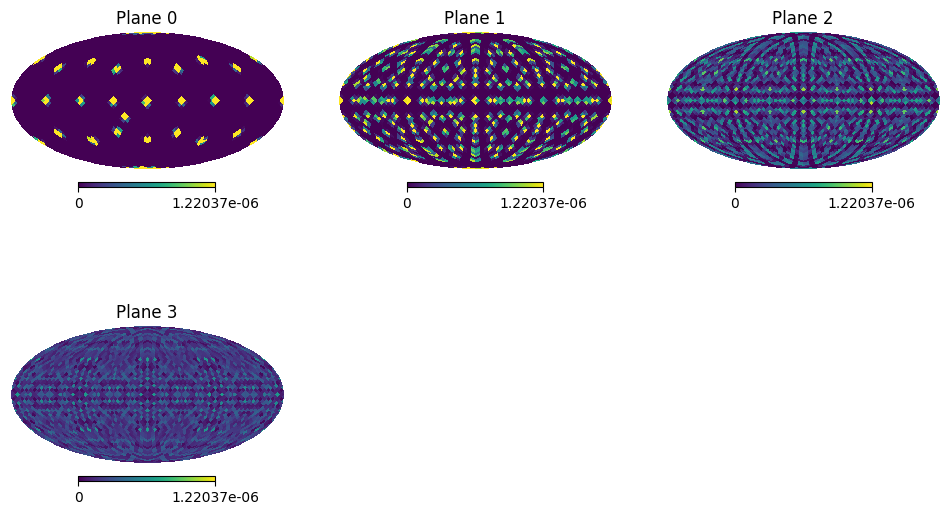

Plotted lightcone


In [6]:
plot_lightcone(true_lightcone, plots_dir, spherical=True, output_format="show")
print("Plotted lightcone")

## Plot Kappa Maps

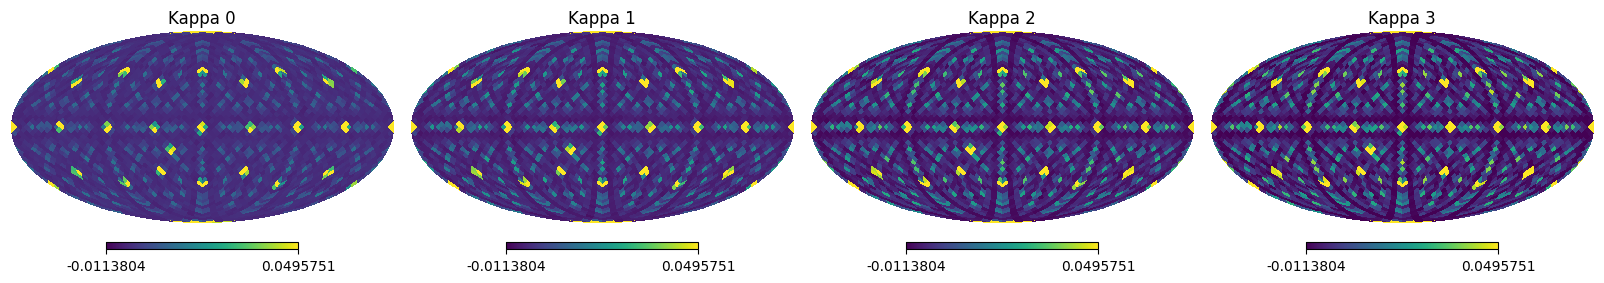

Plotted kappa maps


In [7]:
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=True, output_format="show")
print("Plotted kappa maps")

## Compute Power Spectra using HEALPix anafast

For 4 redshift bins, we compute:
- 4 auto-spectra: C_ell^{ii}
- 6 cross-spectra: C_ell^{ij} for i < j
- Total: 10 power spectra

In [8]:
print("Computing power spectra with healpy.anafast")

observed_cls = {}
ell_max = 3 * config.nside - 1
ell = np.arange(2, ell_max + 1)

for i in range(nbins):
    for j in range(i, nbins):
        kappa_i = np.asarray(true_kappas_full[f"kappa_{i}"])
        kappa_j = np.asarray(true_kappas_full[f"kappa_{j}"])

        cl_full = hp.anafast(kappa_i, kappa_j, lmax=ell_max)
        cl_obs = cl_full[2:]

        observed_cls[(i, j)] = jnp.array(cl_obs)
        print(f"  C_ell^{{{i},{j}}}: {len(cl_obs)} multipoles")

print(f"\nTotal power spectra computed: {len(observed_cls)}")
print(f"Expected: 4 auto + 6 cross = 10 spectra")

np.savez(
    data_dir / "observed_cls.npz",
    **{f"cl_{i}_{j}": observed_cls[(i, j)] for i, j in observed_cls.keys()},
    ell=ell,
)

Computing power spectra with healpy.anafast
  C_ell^{0,0}: 46 multipoles
  C_ell^{0,1}: 46 multipoles
  C_ell^{0,2}: 46 multipoles
  C_ell^{0,3}: 46 multipoles
  C_ell^{1,1}: 46 multipoles
  C_ell^{1,2}: 46 multipoles
  C_ell^{1,3}: 46 multipoles
  C_ell^{2,2}: 46 multipoles
  C_ell^{2,3}: 46 multipoles
  C_ell^{3,3}: 46 multipoles

Total power spectra computed: 10
Expected: 4 auto + 6 cross = 10 spectra


## Plot Power Spectra

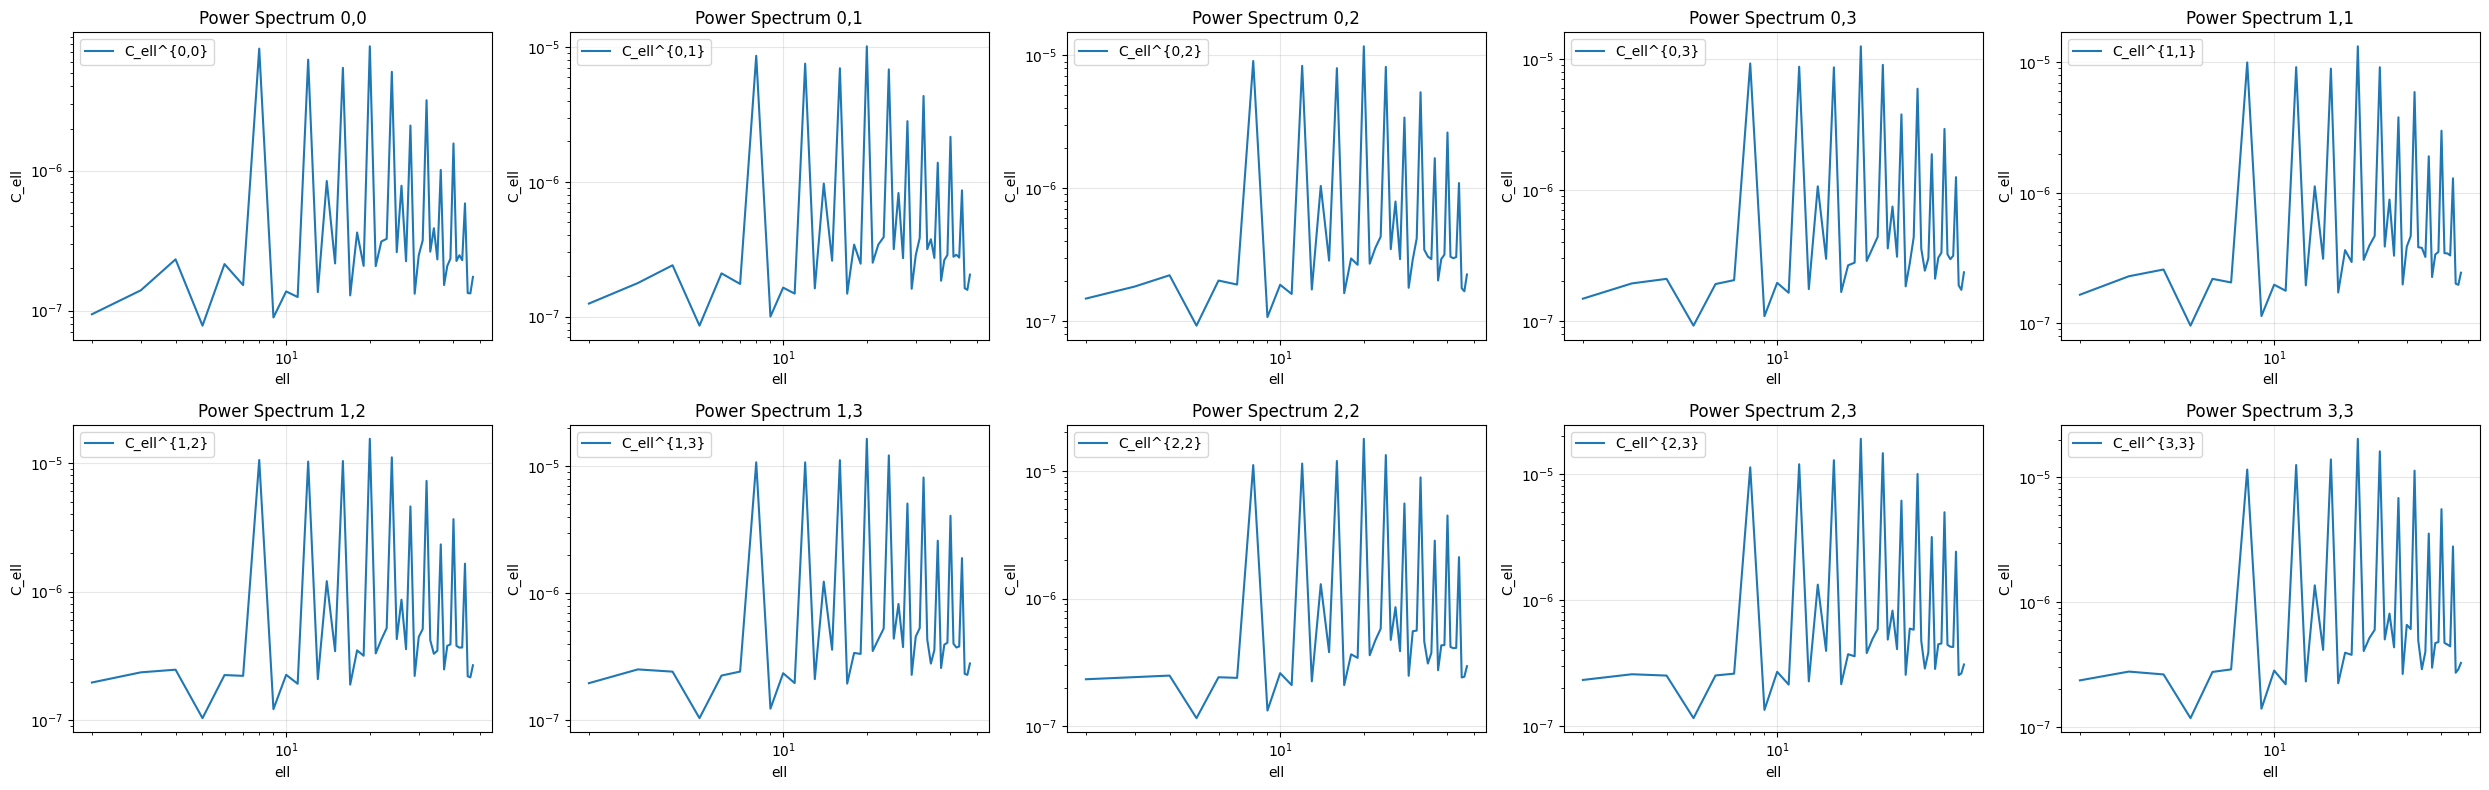

Plotted power spectra


In [9]:
fig, axes = plt.subplots(2, 5, figsize=(25, 8))
axes = axes.ravel()

for idx, (i, j) in enumerate(observed_cls.keys()):
    ax = axes[idx]
    cl = observed_cls[(i, j)]
    ax.loglog(ell, np.abs(cl), label=f"C_ell^{{{i},{j}}}")
    ax.set_xlabel("ell")
    ax.set_ylabel("C_ell")
    ax.set_title(f"Power Spectrum {i},{j}")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()
print("Plotted power spectra")

## Full-Field Inference

### Condition on Kappa Maps

In [ ]:
print("Setting up full-field MCMC inference")

config_inference = config._replace(log_lightcone=False, log_ic=False)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_visible[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}
init_params = jax.tree.map(jnp.asarray, init_params)

print(f"Sampling with {sampler} using {backend} backend")

Setting up full-field MCMC inference
Sampling with MCLMC using blackjax backend


: 

### Run Full-Field Sampling

In [ ]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir_ff),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params,
    progress_bar=True,
)

print("Full-field MCMC sampling completed")

‚ñ∂Ô∏è Resuming for MCLMC using blackjax...
üîß Tuning MCLMC parameters (L and step_size)...


### Load Full-Field Samples

In [ ]:
samples_ff = load_samples(str(samples_dir_ff))
print(f"Loaded {len(samples_ff['Omega_c'])} full-field samples")

print("\nFull-Field Posterior Statistics:")
print(f"Omega_c: {samples_ff['Omega_c'].mean():.4f} ¬± {samples_ff['Omega_c'].std():.4f}")
print(f"sigma8: {samples_ff['sigma8'].mean():.4f} ¬± {samples_ff['sigma8'].std():.4f}")

## Power Spectrum Inference

### Instantiate Power Spectrum Model

In [ ]:
print("Setting up power spectrum MCMC inference")

ell_jax = jnp.array(ell)


def powerspec_model():
    powerspec_probmodel(config, ell_jax, observed_cls)


init_params_ps = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
}
init_params_ps = jax.tree.map(jnp.asarray, init_params_ps)

print(f"Sampling with {sampler} using {backend} backend")

### Run Power Spectrum Sampling

In [ ]:
batched_sampling(
    model=powerspec_model,
    path=str(samples_dir_ps),
    rng_key=jax.random.PRNGKey(magick_seed + 1),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params_ps,
    progress_bar=True,
)

print("Power spectrum MCMC sampling completed")

### Load Power Spectrum Samples

In [ ]:
samples_ps = load_samples(str(samples_dir_ps))
print(f"Loaded {len(samples_ps['Omega_c'])} power spectrum samples")

print("\nPower Spectrum Posterior Statistics:")
print(f"Omega_c: {samples_ps['Omega_c'].mean():.4f} ¬± {samples_ps['Omega_c'].std():.4f}")
print(f"sigma8: {samples_ps['sigma8'].mean():.4f} ¬± {samples_ps['sigma8'].std():.4f}")

## Plot Both Posteriors on Same GetDist Plot

In [ ]:
from getdist import MCSamples
from getdist import plots as gdplots

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

params = ("Omega_c", "sigma8")
labels = [r"\Omega_c", r"\sigma_8"]

samples_ff_array = np.column_stack([samples_ff[p] for p in params])
mc_samples_ff = MCSamples(samples=samples_ff_array, names=params, labels=labels, label="Full-Field")

samples_ps_array = np.column_stack([samples_ps[p] for p in params])
mc_samples_ps = MCSamples(samples=samples_ps_array, names=params, labels=labels, label="Power Spectrum")

markers_dict = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}

gdplt = gdplots.get_subplot_plotter(width_inch=8)

gdplt.triangle_plot(
    [mc_samples_ff, mc_samples_ps],
    filled=True,
    contour_colors=["blue", "red"],
    markers=markers_dict,
    title_limit=1,
    legend_labels=["Full-Field", "Power Spectrum"],
)

plt.savefig(plots_dir / "comparison_posterior.png", dpi=600, bbox_inches="tight")
plt.show()
print("Plotted comparison posteriors")